In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_1.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 9 nodes.
gmshTranslator: Mesh has 9 elements.
gmshTranslator: Processed 22 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [27]:
N_LGL   = 8

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

Xi_LGL, Eta_LGL = utils.af_meshgrid(xi_LGL, eta_LGL)
xi_i  = af.flat(Xi_LGL)
eta_j = af.flat(Eta_LGL)

_, Lp_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lq_eta = lagrange.lagrange_polynomials(eta_LGL)
Lp_xi = af.np_to_af_array(Lp_xi)
Lq_eta = af.np_to_af_array(Lq_eta)

dLp_dxi_coeffs  = utils.polynomial_derivative(Lp_xi)
dLq_deta_coeffs = utils.polynomial_derivative(Lq_eta)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [32]:
Lp_xi_tp = af.reorder(Lp_xi, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tp = af.tile(Lp_xi_tp, d0 = N_LGL)
Lp_xi_tp = af.moddims(Lp_xi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tp = af.reorder(Lp_xi_tp, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tp = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tp = af.tile(Lq_eta_tp, d0 = N_LGL)
Lq_eta_tp = af.reorder(Lq_eta_tp, d0 = 0, d1 = 2, d2 = 1)

In [33]:
dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

In [34]:
def F_xi(u):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    return F_eta_u

In [35]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [38]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

u_ij = np.e ** (- (xi_i**2) / (0.4 ** 2))
u_ij_tile = af.moddims(u_ij, N_LGL, N_LGL)

Lp_Lq_tp = w2d.Li_Lj_coeffs(N_LGL)
volume_integral_00 = 
# Lp_Lq_tp_ij = utils.polyval_2d(Lp_Lq_tp, xi_i, eta_j)


arrayfire.Array()
Type: double

[8 8 64 1]
   11.2330   -11.2330   -12.9611    12.9611     3.5349    -3.5349    -0.1309     0.1309 
  -11.2330    11.2330    12.9611   -12.9611    -3.5349     3.5349     0.1309    -0.1309 
  -12.9611    12.9611    14.9551   -14.9551    -4.0787     4.0787     0.1511    -0.1511 
   12.9611   -12.9611   -14.9551    14.9551     4.0787    -4.0787    -0.1511     0.1511 
    3.5349    -3.5349    -4.0787     4.0787     1.1124    -1.1124    -0.0412     0.0412 
   -3.5349     3.5349     4.0787    -4.0787    -1.1124     1.1124     0.0412    -0.0412 
   -0.1309     0.1309     0.1511    -0.1511    -0.0412     0.0412     0.0015    -0.0015 
    0.1309    -0.1309    -0.1511     0.1511     0.0412    -0.0412    -0.0015     0.0015 

  -27.2841    27.2841    31.4817   -31.4817    -8.5859     8.5859     0.3180    -0.3180 
   23.7847   -23.7847   -27.4439    27.4439     7.4847    -7.4847    -0.2772     0.2772 
   38.0318   -38.0318   -43.8828    43.8828    11.9680   -11.9680 

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


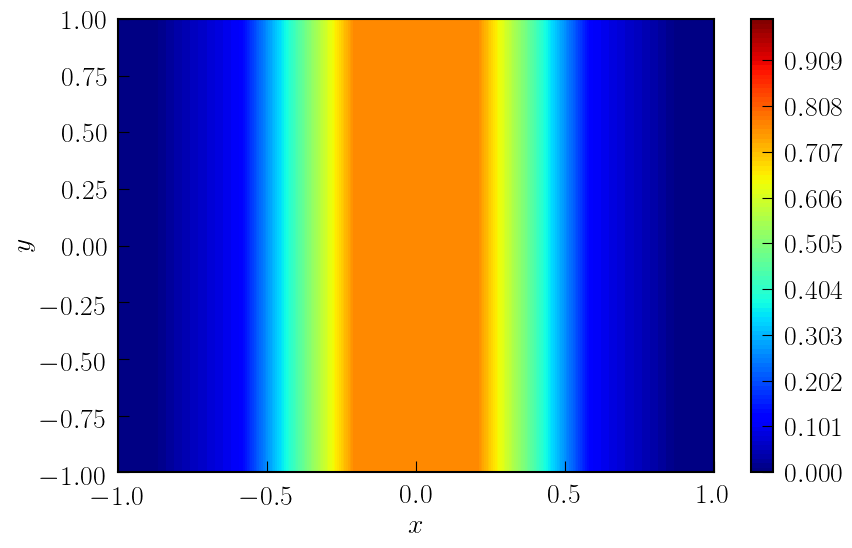

In [14]:
color_levels = np.linspace(0., 1., 100)
plt.contourf(np.array(Xi_LGL), np.array(Eta_LGL), np.array(u_ij_tile),200, levels = color_levels, cmap = 'jet')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()
plt.show()

In [11]:
volume_integral_ij = g_ab[0][0] * 

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [12]:
xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
print(af.sum(params.dl_dxi_coeffs[0, :]))

-0.5000000008859157


In [14]:
# for p in range(N_LGL):
#     for q in range(N_LGL):
p = 0
q = 0

xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
Lp_value_LGL_points = af.transpose(utils.polyval_1d(L_p_coeffs[p], xi_i))
Lq_value_LGL_points = af.transpose(utils.polyval_1d(L_q_coeffs[q], eta_j))

dLp_dxi_LGL_points  = af.transpose(utils.polyval_1d(dLp_dxi_coeffs[p], xi_i))
dLq_deta_LGL_points = af.transpose(utils.polyval_1d(dLq_deta_coeffs[q], eta_j))

g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
print(g_ab[0][0].shape)
g_00 = g_ab[0][0]

#print(F_xi(u_ij).shape, Lq_value_LGL_points.shape, dLp_dxi_LGL_points.shape)
v_00            = g_00 * F_xi(u_ij) * Lq_value_LGL_points * dLp_dxi_LGL_points
volume_integral = af.sum(v_00 * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss'))


print(volume_integral)

(64,)


RuntimeError: In function af::dim4 getOutDims(const af::dim4&, const af::dim4&, bool)
In file src/backend/ArrayInfo.cpp:180
Invalid dimension for argument 1
Expected: ldims == rdims


In [21]:
test_func1 = np.e ** (xi_i + eta_j)
test_func1 = af.np_to_af_array(np.array(test_func1))

print(af.sum(test_func1 * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 8, scheme = 'gauss')))

5.524391382167368


In [59]:
v_interp = v_00 * (utils.polyval_1d(Lp_xi_tile, af.constant(0.5, 1, dtype = af.Dtype.f64)) * utils.polyval_1d(Lq_eta_tile, af.constant(0.5, 1, dtype = af.Dtype.f64)))

In [61]:
print(af.sum(v_interp))

0.0014092098941542869


In [ ]:
-0.000593510743354368

In [ ]:
(0.0008687503716034615 / 0.000424369962806095)

In [ ]:
(0.005125382517612013 / 0.00250366326102057)

In [ ]:
(0.008297813043957767 / 0.00405334228103847)

In [ ]:
0.010033064471541696 / 0.00490098345377580

In [ ]:
print(xi_i)

In [ ]:
xi_i = af.np_to_af_array(np.array(xi_i))
eta_j = af.np_to_af_array(np.array(eta_j))
func = np.e ** (xi_i + eta_j)
print(func)

In [ ]:
print(af.sum(func * utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')))

In [ ]:
utils.integrate_2d(Lp_xi_tile, Lq_eta_tile, order = 9, scheme = 'gauss')

In [ ]:
0.000424369962806095 / 0.0008687503715943605

In [ ]:
-0.00250366326102057 / -0.0051253825175652055

In [ ]:
0.0015928056643658513 / 0.000308073349716018